In [2]:
import copy
import itertools
import logging
import os
from collections import OrderedDict
from typing import Any, Dict, List, Set

import torch

import detectron2.utils.comm as comm
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog, build_detection_train_loader, build_detection_test_loader
from detectron2.engine import DefaultTrainer, default_argument_parser, default_setup, launch
from detectron2.evaluation import (
    CityscapesInstanceEvaluator,
    CityscapesSemSegEvaluator,
    COCOEvaluator,
    COCOPanopticEvaluator,
    DatasetEvaluators,
    SemSegEvaluator,
    verify_results,
)
from tqdm import tqdm
import cv2
from detectron2.projects.deeplab import add_deeplab_config, build_lr_scheduler
from detectron2.solver.build import maybe_add_gradient_clipping
from detectron2.utils.logger import setup_logger

from detectron2.data import MetadataCatalog, DatasetCatalog
# MaskFormer
from mask_former import (
    DETRPanopticDatasetMapper,
    MaskFormerPanopticDatasetMapper,
    MaskFormerSemanticDatasetMapperVSS,
    SemanticSegmentorWithTTA,
    add_mask_former_config
)
import numpy as np
from detectron2.modeling import build_model
import albumentations as A
from albumentations.core.composition import Compose, OneOf

/home/jcurimil/.conda_envs/mask3/lib/python3.9/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)
/home/jcurimil/.conda_envs/mask3/lib/python3.9/site-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.0'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [3]:
cfg = get_cfg()
# for poly lr schedule
add_deeplab_config(cfg)
add_mask_former_config(cfg)
cfg.merge_from_file("configs/ade20k-150/swin/maskformer_swin_base_IN21k_384_bs16_160k_res640.yaml")

Loading config configs/ade20k-150/swin/maskformer_swin_base_IN21k_384_bs16_160k_res640.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.
Loading config configs/ade20k-150/swin/../Base-ADE20K-150.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


In [20]:
path_img="../../../../shared_data/Liver_Vessel_Segmentation/colorectal/data_corrected_2d/images_lv_2d"
path_msk="../../../../shared_data/Liver_Vessel_Segmentation/colorectal/data_corrected_2d/masks_vs_2d"
image_names=os.listdir(path_img)
print(image_names[0])

CRLM-CT-1164_61.npy


In [4]:
import time
from detectron2.data import detection_utils as utils

def get_pred(model,img,msk):
    MEAN=[0.485,0.456,0.406]
    STD=[0.229,0.224,0.225]
    
    image = img.astype(np.float32)
    img_min, img_max = -360, 440
    image = np.clip(image, img_min, img_max)
    image = (image - img_min) / (img_max - img_min)
    sem_seg_gt = msk.astype("double")
    
    if image.ndim == 2:
        image = image[..., None]
        image=image.repeat(3,axis=-1)
    
    transform = Compose([
        A.Resize(512,512),
    ])
    
    image=((image)-MEAN)/STD
    
    augmented = transform(image=image, mask=sem_seg_gt)
    image_test = augmented['image']
    sem_seg_gt = augmented['mask']
    
    sem_seg_gt[sem_seg_gt>0]=1
    image_test = image_test.transpose(2, 0, 1).astype(np.float32) 
    
    
    image_test = torch.tensor(image_test)
    dataset_dict={}
    dataset_dict["image"] = image_test
    with torch.no_grad():
        prediction=model([dataset_dict])[0]['sem_seg'].argmax(dim=0)
    prediction=prediction.detach().cpu().numpy()
    return prediction, sem_seg_gt

In [5]:
import pandas as pd
def create_dict(image_names):
    dict_info={"name":[],"number":[],"slice":[]}
    for i in image_names:
        info=str(i.split("-")[-1])
        numbers=info.split("_")
        patient=numbers[0]
        slide=numbers[1].split(".")[0]
        dict_info["number"].append(patient)
        dict_info["slice"].append(slide.zfill(4))
        dict_info["name"].append(i)
    dataframe=pd.DataFrame(dict_info)
    dataframe=dataframe.sort_values(by=["number","slice"])
    return dataframe

In [9]:
def get_scores(model,number,dataframe,path_img,path_msk):
    masks_patient=[]
    preds_patient=[]
    
    patient_imgs_slices=dataframe[dataframe["number"]==number]["name"]
    for patient_slice in patient_imgs_slices:
        name_img=os.path.join(path_img,patient_slice)
        name_msk=os.path.join(path_msk,patient_slice)
        img=np.load(name_img)
        msk=np.load(name_msk)
        prediction, sem_seg_gt=get_pred(model,img,msk)
        masks_patient.append(sem_seg_gt)
        preds_patient.append(prediction)
    cl_score_patient=cl_score(np.array(preds_patient), np.array(masks_patient))
    clDice_patient=clDice(np.array(preds_patient), np.array(masks_patient))
    binary_dc_patient=binary_dc(np.array(preds_patient), np.array(masks_patient))
    return cl_score_patient,clDice_patient,binary_dc_patient

In [10]:
from skimage.morphology import skeletonize

def cl_score(v, s):
    """[this function computes the skeleton volume overlap]

    Args:
        v ([bool]): [image]
        s ([bool]): [skeleton]

    Returns:
        [float]: [computed skeleton volume intersection]
    """
    cl = np.sum(v*s)/np.sum(s+1e-12)
    return cl


def clDice(v_p, v_l):
    """[this function computes the cldice metric]

    Args:
        v_p ([bool]): [predicted image]
        v_l ([bool]): [ground truth image]

    Returns:
        [float]: [cldice metric]
    """
    tprec = cl_score(v_p,skeletonize(v_l))
    tsens = cl_score(v_l,skeletonize(v_p))
    cl_dice = 2*tprec*tsens/(tprec+tsens+1e-12)
    return cl_dice

def binary_dc(result, reference):
    r"""
    Dice coefficient

    Computes the Dice coefficient (also known as Sorensen index) between the binary
    objects in two images.

    The metric is defined as

    .. math::

        DC=\frac{2|A\cap B|}{|A|+|B|}

    , where :math:A is the first and :math:B the second set of samples (here: binary objects).

    Parameters
    ----------
    result : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.
    reference : array_like
        Input data containing objects. Can be any type but will be converted
        into binary: background where 0, object everywhere else.

    Returns
    -------
    dc : float
        The Dice coefficient between the object(s) in 
result
 and the
        object(s) in 
reference
. It ranges from 0 (no overlap) to 1 (perfect overlap).

    Notes
    -----
    This is a real metric. The binary images can therefore be supplied in any order.
    """
    result = np.atleast_1d(result.astype(bool))
    reference = np.atleast_1d(reference.astype(bool))

    intersection = np.count_nonzero(result & reference)

    size_i1 = np.count_nonzero(result)
    size_i2 = np.count_nonzero(reference)

    try:
        dc = 2. * intersection / float(size_i1 + size_i2)
    except ZeroDivisionError:
        dc = 0.0

    return dc

# COLORECTAL

In [ ]:
results={"kfold":[],"model_path":[],"cl_score_train":[],"clDice_train":[],"binary_dc_train":[],"cl_score_val":[],"clDice_val":[],"binary_dc_val":[]}
model_paths=["model_0004999.pth","model_0009999.pth","model_0014999.pth","model_0019999.pth","model_0024999.pth"]
for i in range(1,6):
    path_img_val=f"../../Data/colorectal_fold/fold_{i}/val/images"
    path_msk_val=f"../../Data/colorectal_fold/fold_{i}/val/masks"
    path_img_train=f"../../Data/colorectal_fold/fold_{i}/train/images"
    path_msk_train=f"../../Data/colorectal_fold/fold_{i}/train/masks"
    image_names_val=os.listdir(path_img_val)
    image_names_train=os.listdir(path_img_train)
    
    dict_val=create_dict(image_names_val)
    dict_train=create_dict(image_names_train)
    
    patients_train=np.unique(dict_train["number"])
    patients_val=np.unique(dict_val["number"])

    for model_path in model_paths:
        model=build_model(cfg)
        checkpoint=torch.load(f"output_base_vss_fold_{i}/{model_path}", map_location="cuda:0")
        model.load_state_dict(checkpoint["model"])
        model.eval()
        cl_score_train=[]
        clDice_patient_train=[]
        binary_dc_patient_train=[]
        for number_train in patients_train:
            cl_score_patient,clDice_patient,binary_dc_patient=get_scores(model,number_train,dict_train,path_img_train,path_msk_train)
            cl_score_train.append(cl_score_patient)
            clDice_patient_train.append(clDice_patient)
            binary_dc_patient_train.append(binary_dc_patient)

        
        cl_score_val=[]
        clDice_patient_val=[]
        binary_dc_patient_val=[]
        for number_val in patients_val:
            cl_score_patient,clDice_patient,binary_dc_patient=get_scores(model,number_val,dict_val,path_img_val,path_msk_val)
            cl_score_val.append(cl_score_patient)
            clDice_patient_val.append(clDice_patient)
            binary_dc_patient_val.append(binary_dc_patient)

        results["kfold"].append(i)
        results["model_path"].append(model_path)
        results["cl_score_train"].append(np.mean(cl_score_train))
        results["clDice_train"].append(np.mean(clDice_patient_train))
        results["binary_dc_train"].append(np.mean(binary_dc_patient_train))
        results["cl_score_val"].append(np.mean(cl_score_val))
        results["clDice_val"].append(np.mean(clDice_patient_val))
        results["binary_dc_val"].append(np.mean(binary_dc_patient_val))
        dataframe_final=pd.DataFrame(results)
        dataframe_final.to_csv('results_colorectal.csv', index=False)  

/home/jcurimil/.conda_envs/mask3/lib/python3.9/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/jcurimil/vssSeg/Code/MaskFormer/mask_former/modeling/transformer/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='fl

(125, 512, 512) (125, 512, 512)
(75, 512, 512) (75, 512, 512)
(38, 512, 512) (38, 512, 512)
(32, 512, 512) (32, 512, 512)
(99, 512, 512) (99, 512, 512)
(30, 512, 512) (30, 512, 512)
(28, 512, 512) (28, 512, 512)
(110, 512, 512) (110, 512, 512)
(114, 512, 512) (114, 512, 512)
(32, 512, 512) (32, 512, 512)
(115, 512, 512) (115, 512, 512)
(84, 512, 512) (84, 512, 512)
(31, 512, 512) (31, 512, 512)
(40, 512, 512) (40, 512, 512)
(71, 512, 512) (71, 512, 512)
(17, 512, 512) (17, 512, 512)
(23, 512, 512) (23, 512, 512)
(32, 512, 512) (32, 512, 512)
(102, 512, 512) (102, 512, 512)
(20, 512, 512) (20, 512, 512)
(37, 512, 512) (37, 512, 512)
(99, 512, 512) (99, 512, 512)
(103, 512, 512) (103, 512, 512)
(27, 512, 512) (27, 512, 512)
(47, 512, 512) (47, 512, 512)
(30, 512, 512) (30, 512, 512)
(35, 512, 512) (35, 512, 512)
(22, 512, 512) (22, 512, 512)
(101, 512, 512) (101, 512, 512)
(33, 512, 512) (33, 512, 512)
(35, 512, 512) (35, 512, 512)
(20, 512, 512) (20, 512, 512)
(33, 512, 512) (33, 512, 5

# ircad

In [35]:
import pandas as pd
def create_dict_ircad(image_names):
    dict_info={"name":[],"number":[],"slice":[]}
    for i in image_names:
        numbers=i.split("_")
        patient=numbers[1]
        slide=numbers[2].split(".")[0]
        dict_info["number"].append(patient)
        dict_info["slice"].append(slide.zfill(4))
        dict_info["name"].append(i)
    dataframe=pd.DataFrame(dict_info)
    dataframe=dataframe.sort_values(by=["number","slice"])
    return dataframe

In [37]:
results={"model_path":[],"cl_score_test":[],"clDice_test":[],"binary_dc_test":[]}
model_paths=["output_base_vss_fold_1/model_0024999.pth","output_base_vss_fold_2/model_0019999.pth","output_base_vss_fold_3/model_0009999.pth"
             ,"output_base_vss_fold_4/model_0019999.pth","output_base_vss_fold_5/model_0014999.pth"]

path_img_test="../../../../shared_data/Liver_Vessel_Segmentation/ircad/data_corrected_2d/images_lv_2d/"
path_msk_test="../../../../shared_data/Liver_Vessel_Segmentation/ircad/data_corrected_2d/masks_vs_2d/"

image_names_test=os.listdir(path_img_test)

dict_test=create_dict_ircad(image_names_test)

patients_test=np.unique(dict_test["number"])

for model_path in model_paths:
    model=build_model(cfg)
    checkpoint=torch.load(model_path, map_location="cuda:0")
    model.load_state_dict(checkpoint["model"])
    model.eval()
    cl_score_test=[]
    clDice_patient_test=[]
    binary_dc_patient_test=[]
    for number_test in patients_test:
        cl_score_patient,clDice_patient,binary_dc_patient=get_scores(model,number_test,dict_test,path_img_test,path_msk_test)
        cl_score_test.append(cl_score_patient)
        clDice_patient_test.append(clDice_patient)
        binary_dc_patient_test.append(binary_dc_patient)

    results["model_path"].append(model_path)
    results["cl_score_test"].append(np.mean(cl_score_test))
    results["clDice_test"].append(np.mean(clDice_patient_test))
    results["binary_dc_test"].append(np.mean(binary_dc_patient_test))
    dataframe_final=pd.DataFrame(results)
    dataframe_final.to_csv('results_ircad.csv', index=False)  

/home/jcurimil/.conda_envs/mask3/lib/python3.9/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/jcurimil/vssSeg/Code/MaskFormer/mask_former/modeling/transformer/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='fl

(98, 512, 512) (98, 512, 512)
(99, 512, 512) (99, 512, 512)
(96, 512, 512) (96, 512, 512)
(239, 512, 512) (239, 512, 512)
(90, 512, 512) (90, 512, 512)
(104, 512, 512) (104, 512, 512)
(115, 512, 512) (115, 512, 512)
(113, 512, 512) (113, 512, 512)
(113, 512, 512) (113, 512, 512)
(59, 512, 512) (59, 512, 512)
(41, 512, 512) (41, 512, 512)
(114, 512, 512) (114, 512, 512)
(85, 512, 512) (85, 512, 512)
(123, 512, 512) (123, 512, 512)
(67, 512, 512) (67, 512, 512)
(119, 512, 512) (119, 512, 512)
(96, 512, 512) (96, 512, 512)
(98, 512, 512) (98, 512, 512)
(116, 512, 512) (116, 512, 512)
(89, 512, 512) (89, 512, 512)
(98, 512, 512) (98, 512, 512)
(99, 512, 512) (99, 512, 512)
(96, 512, 512) (96, 512, 512)
(239, 512, 512) (239, 512, 512)
(90, 512, 512) (90, 512, 512)
(104, 512, 512) (104, 512, 512)
(115, 512, 512) (115, 512, 512)
(113, 512, 512) (113, 512, 512)
(113, 512, 512) (113, 512, 512)
(59, 512, 512) (59, 512, 512)
(41, 512, 512) (41, 512, 512)
(114, 512, 512) (114, 512, 512)
(85, 512, 

# Decathlon

In [ ]:
results={"model_path":[],"cl_score_test":[],"clDice_test":[],"binary_dc_test":[]}
model_paths=["output_base_vss_fold_1/model_0024999.pth","output_base_vss_fold_2/model_0019999.pth","output_base_vss_fold_3/model_0009999.pth"
             ,"output_base_vss_fold_4/model_0019999.pth","output_base_vss_fold_5/model_0014999.pth"]

path_img_test="../../../../shared_data/Liver_Vessel_Segmentation/decathlon/data_corrected_2d/images_lvin_wot_2d/"
path_msk_test="../../../../shared_data/Liver_Vessel_Segmentation/decathlon/data_corrected_2d/labels_vs_lv_in_2d/"

image_names_test=os.listdir(path_img_test)

dict_test=create_dict_ircad(image_names_test)

patients_test=np.unique(dict_test["number"])

for model_path in model_paths:
    model=build_model(cfg)
    checkpoint=torch.load(model_path, map_location="cuda:0")
    model.load_state_dict(checkpoint["model"])
    model.eval()
    cl_score_test=[]
    clDice_patient_test=[]
    binary_dc_patient_test=[]
    for number_test in patients_test:
        cl_score_patient,clDice_patient,binary_dc_patient=get_scores(model,number_test,dict_test,path_img_test,path_msk_test)
        cl_score_test.append(cl_score_patient)
        clDice_patient_test.append(clDice_patient)
        binary_dc_patient_test.append(binary_dc_patient)

    results["model_path"].append(model_path)
    results["cl_score_test"].append(np.mean(cl_score_test))
    results["clDice_test"].append(np.mean(clDice_patient_test))
    results["binary_dc_test"].append(np.mean(binary_dc_patient_test))
    dataframe_final=pd.DataFrame(results)
    dataframe_final.to_csv('results_decathlon.csv', index=False)  

/home/jcurimil/.conda_envs/mask3/lib/python3.9/site-packages/detectron2/structures/image_list.py:88: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  max_size = (max_size + (stride - 1)) // stride * stride
/home/jcurimil/vssSeg/Code/MaskFormer/mask_former/modeling/transformer/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='fl

(37, 512, 512) (37, 512, 512)
(48, 512, 512) (48, 512, 512)
(29, 512, 512) (29, 512, 512)
(25, 512, 512) (25, 512, 512)
(42, 512, 512) (42, 512, 512)
(38, 512, 512) (38, 512, 512)
(38, 512, 512) (38, 512, 512)
(27, 512, 512) (27, 512, 512)
(34, 512, 512) (34, 512, 512)
(29, 512, 512) (29, 512, 512)
(30, 512, 512) (30, 512, 512)
(29, 512, 512) (29, 512, 512)
(33, 512, 512) (33, 512, 512)
(30, 512, 512) (30, 512, 512)
(41, 512, 512) (41, 512, 512)


In [42]:
path_img_test="../../../../shared_data/Liver_Vessel_Segmentation/decathlon/data_corrected_2d/images_lvin_wot_2d/"

image_names_test=os.listdir(path_img_test)
create_dict_ircad(image_names_test)

,name,number,slice
8839,hepaticvessel_001_0.npy,001,0000
8476,hepaticvessel_001_1.npy,001,0001
10282,hepaticvessel_001_2.npy,001,0002
4005,hepaticvessel_001_3.npy,001,0003
5256,hepaticvessel_001_4.npy,001,0004
...,...,...,...
7688,hepaticvessel_458_134.npy,458,0134
13345,hepaticvessel_458_135.npy,458,0135
9712,hepaticvessel_458_136.npy,458,0136
10252,hepaticvessel_458_137.npy,458,0137


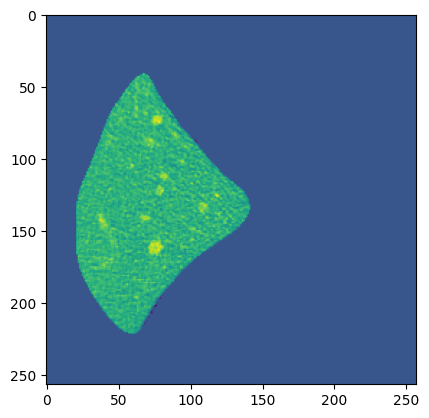

In [28]:
import matplotlib.pyplot as plt
name_img=os.path.join(path_img,image_names[0])
name_msk=os.path.join(path_msk,image_names[0])
img=np.load(name_img)
plt.imshow(img)

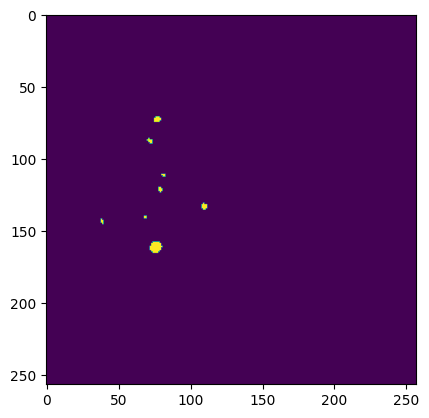

In [29]:
msk=np.load(name_msk)
plt.imshow(msk)

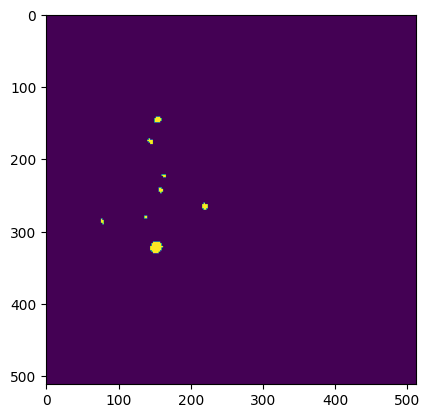

In [40]:
plt.imshow(sem_seg_gt)

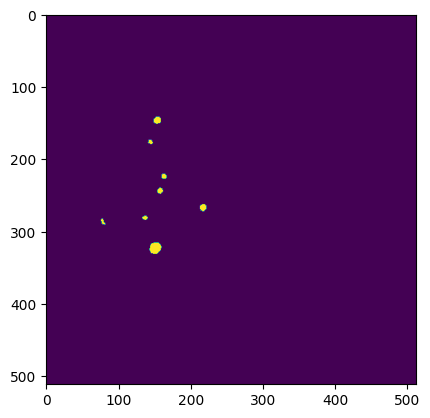

In [38]:
plt.imshow(prediction)

In [16]:
results_colo=pd.read_csv("results_colorectal.csv")

In [22]:
results_colo[results_colo["kfold"]==5]

,kfold,model_path,cl_score_train,clDice_train,binary_dc_train,cl_score_val,clDice_val,binary_dc_val
20,5,model_0004999.pth,0.737980,0.765768,0.746954,0.722420,0.761915,0.733903
21,5,model_0009999.pth,0.757085,0.797135,0.780830,0.711897,0.762985,0.730141
22,5,model_0014999.pth,0.820217,0.828023,0.814149,0.740064,0.764929,0.732510
23,5,model_0019999.pth,0.818801,0.841888,0.831005,0.717968,0.758572,0.729618
24,5,model_0024999.pth,0.842205,0.854411,0.841205,0.726220,0.761026,0.730040


In [32]:
ls ../../../../shared_data/Liver_Vessel_Segmentation/ircad/data_corrected_2d

images_lv_2d/  masks_vs_2d/
